# Plotando com Makie 

Existem diversos pacotes para plotagem com Julia (e.g. Plots.jl, VegaLite.jl, Gadfly.jl,...), entretanto,
o pacote Makie vem ganhando destaque. Na comunidade de Julia, é comum ouvir que "Makie is the future!".
As razões são diversas, entre elas está o fato de o pacote ser totalmente nativo em Julia, simples iteratividade,
bom sistema de layout, entre outros. Mas o que me convenceu (e possivelmente outros da comunidade),
foram alguns dos belíssimos exmemplos de plots como os presentes no repositório [BeautifulMakie](https://lazarusa.github.io/BeautifulMakie/).

Além disso, muitos pacotes interessantes tem sido construídos em cima do Makie, como o [AlgebraOfGraphics.jl](https://github.com/JuliaPlots/AlgebraOfGraphics.jl).

Entretanto, é preciso falar alguns dos atuais "shortcomings" do Makie. O primeiro é algo bastante
comum para quem usa Julia. O primeiro plot leva um tempo considerável devido ao tempo de pré-compilção (felizmente,
isso pode ser contornado com o PkgCompiler.jl, olhe esse meu [artigo aqui](https://medium.com/coffee-in-a-klein-bottle/speeding-up-julia-precompilation-97f39d151a9f)). O segundo problema é que o pacote ainda está em franco desenvolvimento, e não está tão maduro
como o Plots.jl. Assim, não é incomum encontrar bugs de vez em quando, ou descobrir que uma feature
específica ainda não foi implementada.

Mesmo assim, esses são somente percalços frente ao que o Makie pode oferecer.

*obs: sugiro fortemente seguir o tutorial [aqui](https://medium.com/coffee-in-a-klein-bottle/speeding-up-julia-precompilation-97f39d151a9f) para
agilizar a pré-compilação.*

O primeiro ponto não convencional ao se usar o Makie é o fato que ele permimte o uso de diferentes
backends para plotagem. Você pode olhar na documentação, mas vamos falar de dois especificamente, eles são o CairoMakie
e o GLMakie. O CairoMakie produz imagens estáticas e de alta qualidade (e.g. svg), sendo assim ideal para usar
quando se quer produzir um imagem para publicação. Já o GLMakie requer que você tenha instalado no seu computador
o OpenGL, e ao plotar é aberta uma janela iterativa contendo o plot. Assim, ele é ideal para, por exemplo,
imagens 3D, onde o usuário costuma querer rotacionar a imagem para obter uma melhor visualização.

In [7]:
using CairoMakie
CairoMakie.activate!(type = "svg")
using AlgebraOfGraphics
kwargs = AlgebraOfGraphics.aog_theme()
set_theme!(;resolution=(400,400),kwargs...)

In [8]:
f = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (1000, 700));

In [9]:
ga = f[1, 1] = GridLayout()
gb = f[2, 1] = GridLayout()
gcd = f[1:2, 2] = GridLayout()
gc = gcd[1, 1] = GridLayout()
gd = gcd[2, 1] = GridLayout()

GridLayout[1, 1] with 0 children


In [10]:
fig, ax, pltobj = scatterlines(1:10);

In [220]:
propertynames(ax.elements[:yaxis])

(:parent, :protrusion, :attributes, :elements, :tickpositions, :tickvalues, :ticklabels, :minortickpositions, :minortickvalues)

In [16]:
ax.attributes[:flipsig]

Attributes with 120 entries:
  alignmode => Inside()
  aspect => nothing
  autolimitaspect => nothing
  backgroundcolor => white
  bottomspinecolor => darkgray
  bottomspinevisible => true
  flip_ylabel => false
  halign => center
  height => nothing
  leftspinecolor => darkgray
  leftspinevisible => true
  limits => (nothing, nothing)
  palette => Attributes with 5 entries:
    color => ColorTypes.RGB{Float64}[RGB{Float64}(0.0,0.447059,0.698039), RGB{Float64}(0.901961,0.623529,0.0), RGB{Float64}(0.0,0.619608,0.45098), RGB{Float64}(0.8,0.47451,0.654902), RGB{Float64}(0.337255,0.705882,0.913725), RGB{Float64}(0.835294,0.368627,0.0), RGB{Float64}(0.941176,0.894118,0.258824)]
    linestyle => [:solid, :dash, :dot, :dashdot, :dashdotdot]
    marker => [:circle, :utriangle, :cross, :rect, :diamond, :dtriangle, :pentagon, :xcross]
    patchcolor => ColorTypes.RGB{Float64}[RGB{Float64}(0.0,0.447059,0.698039), RGB{Float64}(0.901961,0.623529,0.0), RGB{Float64}(0.0,0.619608,0.45098), RGB{Float64

In [13]:
pltobj.attributes

Attributes with 14 entries:
  color => gray25
  colormap => batlow
  colorrange => Automatic()
  inspectable => true
  linestyle => nothing
  linewidth => 1.5
  marker => circle
  markercolor => gray25
  markercolormap => batlow
  markercolorrange => Automatic()
  markersize => 9
  model => Float32[1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0]
  strokecolor => black
  strokewidth => 0

In [212]:
figure = (; figure_padding=5, resolution=(600,400),
    backgroundcolor=:grey90, fontsize=16, font="sans")

axis = (; xlabel="x", ylabel="x²", title="title",
    backgroundcolor=:white, xgridstyle=:dash, ygridstyle=:dash)

f,ax, pltobj = lines(1:10, (1:10).^2; color=:black, linewidth=2, linestyle=:dash, figure, axis);

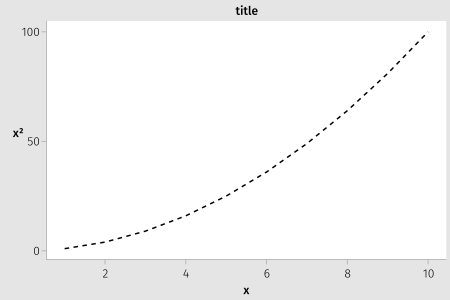

In [215]:
f

In [214]:
ax.elements[:yaxis].elements[:labeltext].attributes[:rotation]= 0.0

0.0

In [202]:
ax.attributes

Attributes with 120 entries:
  alignmode => Inside()
  aspect => nothing
  autolimitaspect => nothing
  backgroundcolor => white
  bottomspinecolor => darkgray
  bottomspinevisible => true
  flip_ylabel => false
  halign => center
  height => nothing
  leftspinecolor => darkgray
  leftspinevisible => true
  limits => (nothing, nothing)
  palette => Attributes with 5 entries:
    color => ColorTypes.RGB{Float64}[RGB{Float64}(0.0,0.447059,0.698039), RGB{Float64}(0.901961,0.623529,0.0), RGB{Float64}(0.0,0.619608,0.45098), RGB{Float64}(0.8,0.47451,0.654902), RGB{Float64}(0.337255,0.705882,0.913725), RGB{Float64}(0.835294,0.368627,0.0), RGB{Float64}(0.941176,0.894118,0.258824)]
    linestyle => [:solid, :dash, :dot, :dashdot, :dashdotdot]
    marker => [:circle, :utriangle, :cross, :rect, :diamond, :dtriangle, :pentagon, :xcross]
    patchcolor => ColorTypes.RGB{Float64}[RGB{Float64}(0.0,0.447059,0.698039), RGB{Float64}(0.901961,0.623529,0.0), RGB{Float64}(0.0,0.619608,0.45098), RGB{Float64

In [201]:
ax.elements[:xaxis].attributes

Attributes with 38 entries:
  actual_ticklabelspace => 19.2
  endpoints => (Float32[62.0, 54.0], Float32[595.0, 54.0])
  flip_vertical_label => false
  flipped => false
  label => x
  labelcolor => black
  labelfont => /home/davibarreira/.julia/packages/AlgebraOfGraphics/LGGSX/assets/fonts/FiraSans-Medium.ttf
  labelpadding => 3.0
  labelsize => 16
  labelvisible => true
  limits => (0.55, 10.45)
  minortickalign => 0.0
  minortickcolor => black
  minorticks => IntervalsBetween(2, true)
  minorticksize => 4.0
  minorticksvisible => false
  minortickwidth => 1.0
  reversed => false
  scale => identity
  spinecolor => darkgray
  spinevisible => true
  spinewidth => 1.0
  tickalign => 0.0
  tickcolor => darkgray
  tickformat => Automatic()
  ticklabelalign => Automatic()
  ticklabelcolor => black
  ticklabelfont => /home/davibarreira/.julia/packages/AlgebraOfGraphics/LGGSX/assets/fonts/FiraSans-Light.ttf
  ticklabelpad => 2.0
  ticklabelrotation => 0.0
  ticklabelsize => 16
  ticklabelspa

In [44]:
ax.elements[:yaxis].attributes[:flipped] = true

true